#Oluomachukwu Otuadinma

#Exploring NLP Techniques for Spam Detection: A Comparative Evaluation of Classifiers

The aim is to build a machine learning model for text classification specifically classification of SMS messages using the SMS Spam Collection Dataset from the UCI Machine Learning Repository. The dataset contains labeled messages as either:

"Spam" — unsolicited, often promotional or malicious messages, or   
"Ham" — legitimate, non-spam messages.

The core objective is to automatically classify SMS messages as either spam or ham using supervised machine learning techniques based on the content of the message text.

##Importing the Data

In [ ]:
!pip install ucimlrepo
!pip install nltk
!pip show nltk
!pip install tldextract
%matplotlib inline

Name: nltk
Version: 3.9.1
Summary: Natural Language Toolkit
Home-page: https://www.nltk.org/
Author: NLTK Team
Author-email: nltk.team@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: click, joblib, regex, tqdm
Required-by: textblob


In [ ]:
import os
import requests
import zipfile
import pathlib

import nltk
import re

import seaborn as sns
import pandas as pd
import numpy as np
import tldextract

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import matplotlib.pyplot as plt

First i import and save the data to a local file making it easier to access

In [ ]:
# Create dataset directory
dataset_url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"

DATASET_DIR = 'ham_spam'
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)

zip_file_path = os.path.join(DATASET_DIR, 'sms+spam+collection.zip')
extracted_dir = os.path.join(DATASET_DIR,'sms+spam+collection')

spam_file_path = os.path.join(DATASET_DIR, 'SMSSpamCollection')

# Download the file
if not os.path.exists(zip_file_path):
  print("Downloading Datasets...")
  response = requests.get(dataset_url)
  with open(zip_file_path, 'wb') as f:
      f.write(response.content)
  print(f"File downloaded to: {zip_file_path}")
else:
  print(f"File already exists at: {zip_file_path}")

ex_file_path = os.path.join(DATASET_DIR, 'SMSSpamCollection')

# Extract the zip files if the extracted file doesn't exist
if not os.path.exists(ex_file_path):
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
    print(f"Extracted to: {DATASET_DIR}")
else:
    print(f"File already extracted to: {ex_file_path}")

File already exists at: ham_spam/sms+spam+collection.zip
File already extracted to: ham_spam/SMSSpamCollection


In [ ]:
with open(ex_file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Print first 5 lines
for line in lines[:5]:
    print(line.strip())

df = pd.read_csv(ex_file_path, sep='\t', header=None, names=['label', 'message'])

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though


Exploring the Data to get an understanding of what I am working with

In [ ]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Clean the Data

In [ ]:
# Check for duplicate rows based on 'rewire_id' and 'text'
duplicate_entries = df[df.duplicated(subset=["label", "message"])]

# Display results
print(f"Number of duplicate rows: {duplicate_entries.shape[0]}")
print(duplicate_entries)

Number of duplicate rows: 403
     label                                            message
103    ham  As per your request 'Melle Melle (Oru Minnamin...
154    ham  As per your request 'Melle Melle (Oru Minnamin...
207    ham  As I entered my cabin my PA said, '' Happy B'd...
223    ham                             Sorry, I'll call later
326    ham                   No calls..messages..missed calls
...    ...                                                ...
5524  spam  You are awarded a SiPix Digital Camera! call 0...
5535   ham  I know you are thinkin malaria. But relax, chi...
5539   ham                         Just sleeping..and surfing
5553   ham                        Hahaha..use your brain dear
5558   ham                             Sorry, I'll call later

[403 rows x 2 columns]


In [ ]:
# Remove the duplicates
df = df.drop_duplicates(subset=["label", "message"])
print(f"Number of rows after removing duplicates: {df.shape[0]}")
print(df.head())

Number of rows after removing duplicates: 5169
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
# These are required packages for the nlp pre-processing stage
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Initialise NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text and extract domains
def clean_text(text, lowercase=True, remove_stopwords=True, lemmatize=True):
    if lowercase:
        text = text.lower()

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens) # Convert tokens back to string


In [ ]:
# Apply function to the dataset
df["message"] = df["message"].apply(clean_text)

# Display results
print(df.head())

  label                                            message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry wkly comp win fa cup final tkts st ...
3   ham                u dun say early hor u c already say
4   ham           nah dont think go usf life around though


##Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC

###Logistic Regression

Average Accuracy: 0.9575725338491295
Average Precision: 0.9868006019171242
Average Recall: 0.6712005089118788
Average F1-Score: 0.7981081111344308


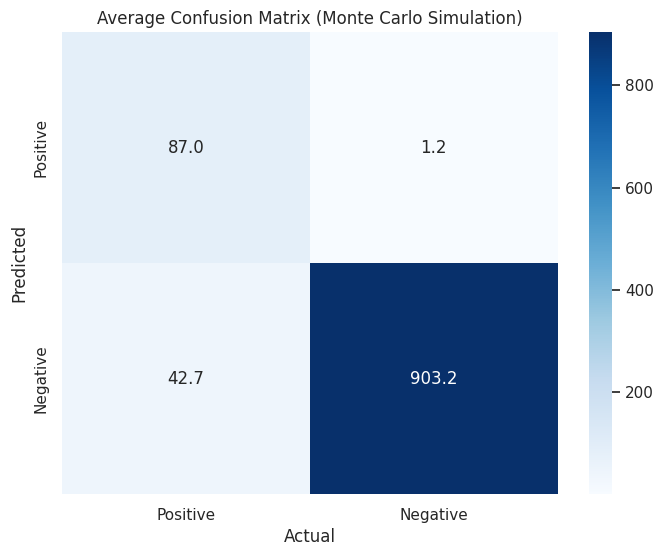

In [ ]:
# Encode labels (spam = 1, ham = 0)
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})

# Initialize storage for metrics and number of iterations
n_iterations = 100
logistic_metrics = {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "conf_matrices": []}

# Labels for the confusion matrix
labels = ['Positive', 'Negative']

# Monte Carlo loop
for i in range(n_iterations):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label_encoded'], test_size=0.2, random_state=i)

    # Vectorize the cleaned text using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)  # Transforms text into a TF-IDF matrix
    X_test_tfidf = vectorizer.transform(X_test)

    # Train model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred = model.predict(X_test_tfidf)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store metrics
    logistic_metrics["accuracy"].append(acc)
    logistic_metrics["precision"].append(prec)
    logistic_metrics["recall"].append(rec)
    logistic_metrics["f1_score"].append(f1)
    logistic_metrics["conf_matrices"].append(conf_matrix)


# Average metrics
print("Average Accuracy:", np.mean(logistic_metrics["accuracy"]))
print("Average Precision:", np.mean(logistic_metrics["precision"]))
print("Average Recall:", np.mean(logistic_metrics["recall"]))
print("Average F1-Score:", np.mean(logistic_metrics["f1_score"]))

# Plot average confusion matrix
avg_conf_matrix = np.mean(logistic_metrics["conf_matrices"], axis=0)

conf_matrix_custom = np.array([[avg_conf_matrix[1, 1], avg_conf_matrix[0, 1]],  # TP, FN
                               [avg_conf_matrix[1, 0], avg_conf_matrix[0, 0]]]) # FP, TN

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_custom, annot=True, fmt=".1f", cmap="Blues",
            yticklabels=labels, xticklabels=labels)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Average Confusion Matrix (Monte Carlo Simulation)")
plt.show()


####Evaluation

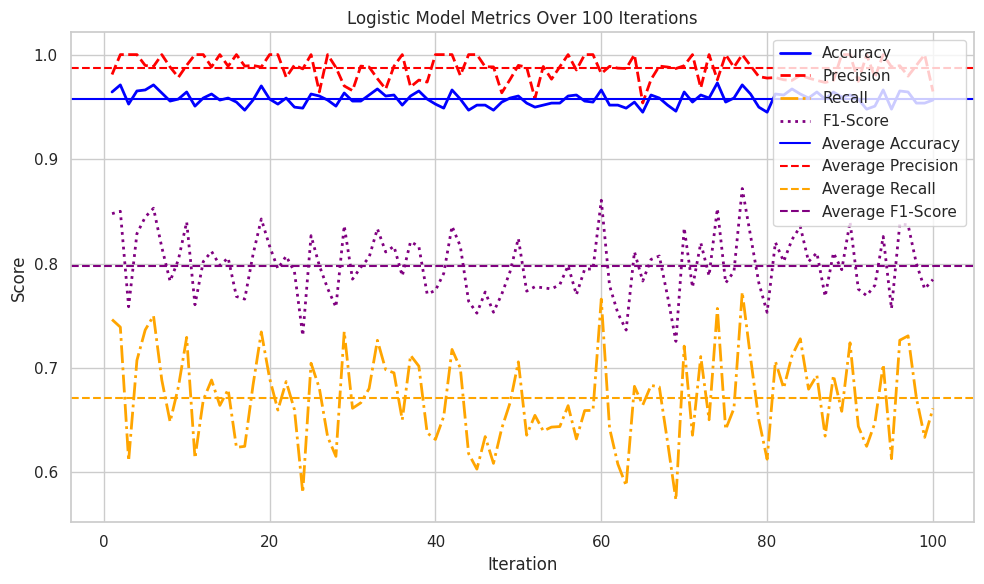

In [ ]:
# Plot all metrics in one plot
plt.figure(figsize=(10, 6))

# Plot accuracy, precision, recall, and F1-score
plt.plot(range(1, n_iterations + 1), logistic_metrics["accuracy"], label="Accuracy", color='blue', linestyle='-', linewidth=2)
plt.plot(range(1, n_iterations + 1), logistic_metrics["precision"], label="Precision", color='red', linestyle='--', linewidth=2)
plt.plot(range(1, n_iterations + 1), logistic_metrics["recall"], label="Recall", color='orange', linestyle='-.', linewidth=2)
plt.plot(range(1, n_iterations + 1), logistic_metrics["f1_score"], label="F1-Score", color='purple', linestyle=':', linewidth=2)

# Plot average lines
plt.axhline(np.mean(logistic_metrics["accuracy"]), color='blue', linestyle='-', label='Average Accuracy')
plt.axhline(np.mean(logistic_metrics["precision"]), color='red', linestyle='--', label='Average Precision')
plt.axhline(np.mean(logistic_metrics["recall"]), color='orange', linestyle='--', label='Average Recall')
plt.axhline(np.mean(logistic_metrics["f1_score"]), color='purple', linestyle='--', label='Average F1-Score')

# Customize plot
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Logistic Model Metrics Over 100 Iterations')
plt.legend(loc='upper right')
plt.tight_layout()

# Show plot
plt.show()

<ipython-input-100-e6ae50ea1362>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette=color)


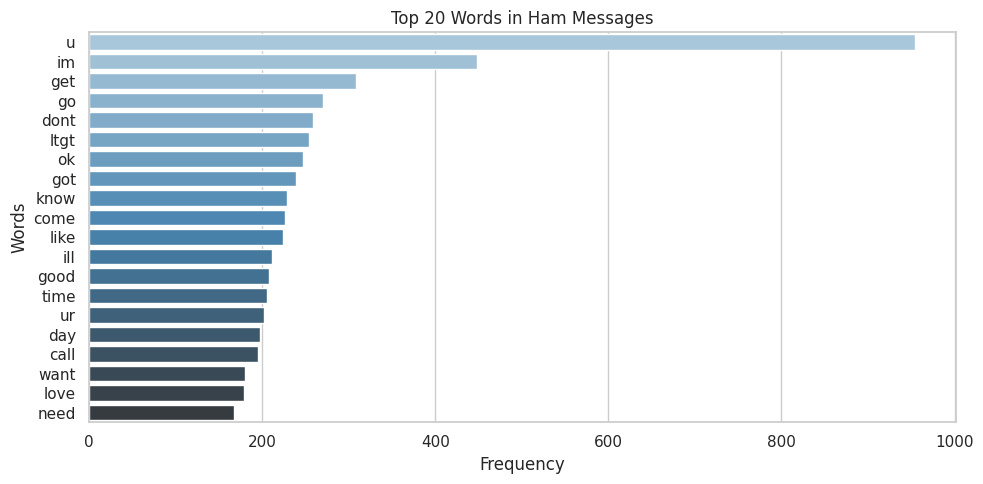

<ipython-input-100-e6ae50ea1362>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette=color)


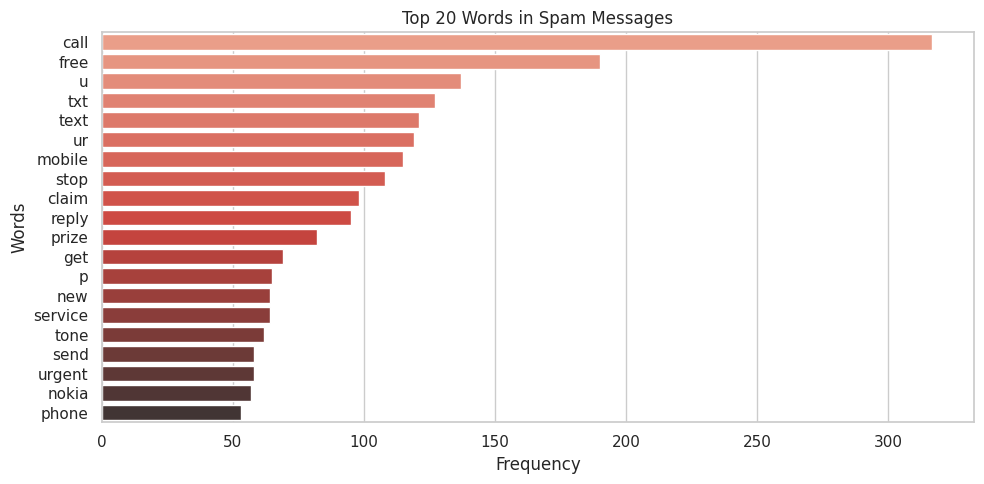

In [ ]:
from collections import Counter

# Separate ham and spam messages
ham_words = ' '.join(df[df['label'] == 'ham']['message']).split()
spam_words = ' '.join(df[df['label'] == 'spam']['message']).split()

# Count word frequencies
ham_freq = Counter(ham_words)
spam_freq = Counter(spam_words)

# Top 20 most common
ham_common = ham_freq.most_common(20)
spam_common = spam_freq.most_common(20)

# Plotting
def plot_word_freq(word_freq, title, color):
    words, counts = zip(*word_freq)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette=color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

plot_word_freq(ham_common, 'Top 20 Words in Ham Messages', 'Blues_d')
plot_word_freq(spam_common, 'Top 20 Words in Spam Messages', 'Reds_d')


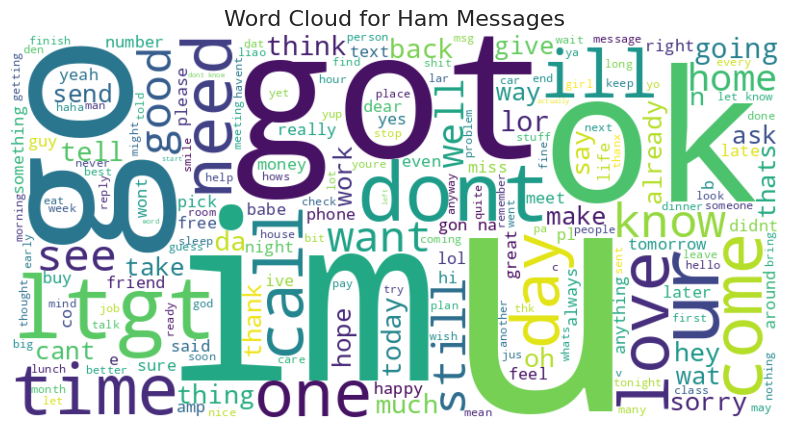

In [ ]:
from wordcloud import WordCloud

# Generate WordClouds
def generate_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

generate_wordcloud(' '.join(ham_words), 'Word Cloud for Ham Messages')

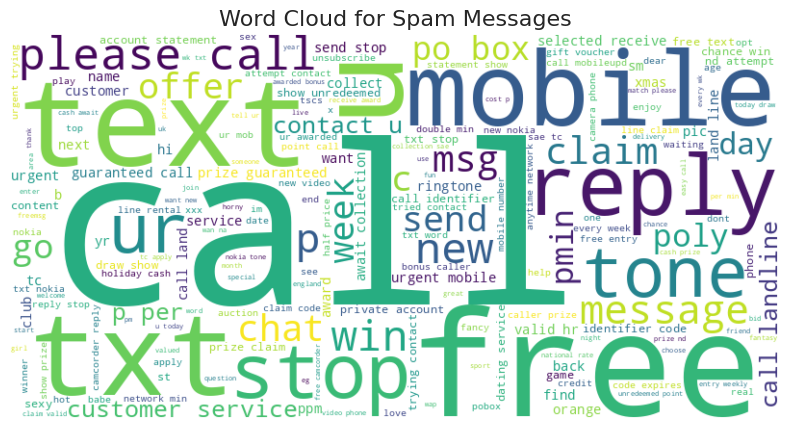

In [ ]:
generate_wordcloud(' '.join(spam_words), 'Word Cloud for Spam Messages')

###Comparison with other models (NB, SVM, RF)

### **Naive Bayes**

Average Accuracy: 0.9589
Average Precision: 0.9995
Average Recall: 0.6733
Average F1-Score: 0.8040


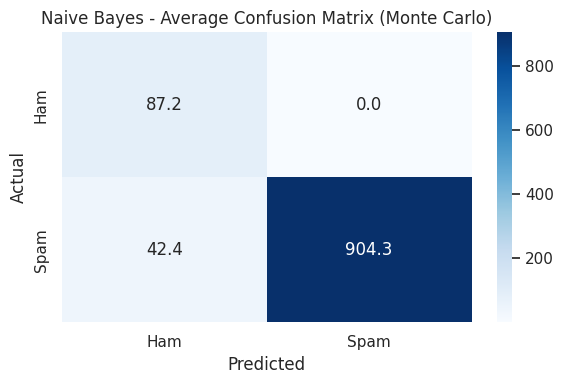

### **SVM**

Average Accuracy: 0.9757
Average Precision: 0.9789
Average Recall: 0.8246
Average F1-Score: 0.8947


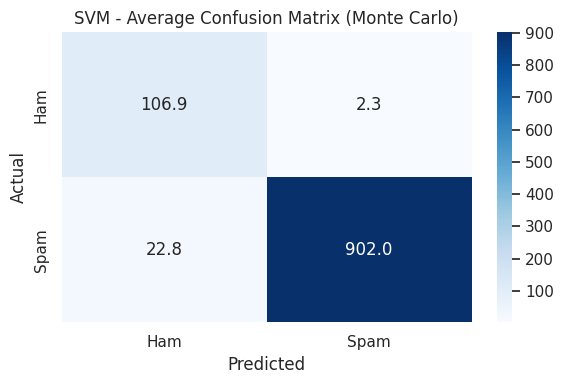

### **Random Forest Classifier**

Average Accuracy: 0.9701
Average Precision: 0.9929
Average Recall: 0.7678
Average F1-Score: 0.8654


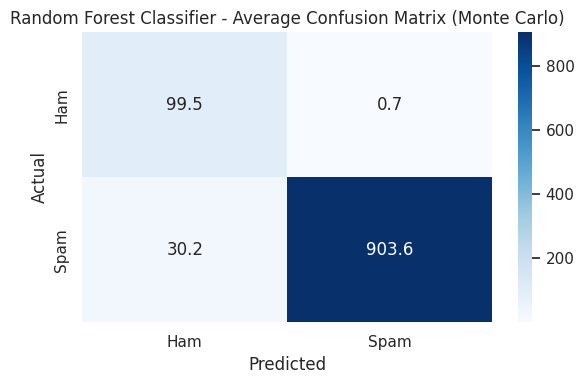

In [ ]:
from IPython.display import display, Markdown

models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42)
}

all_metrics = {name: {"accuracy": [], "precision": [], "recall": [], "f1_score": [], "conf_matrices": []} for name in models.keys()}

# Monte Carlo Simulation
for i in range(n_iterations):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df["message"])
    y = df["label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label="spam")
        rec = recall_score(y_test, y_pred, pos_label="spam")
        f1 = f1_score(y_test, y_pred, pos_label="spam")
        conf = confusion_matrix(y_test, y_pred)

        # Store
        all_metrics[name]["accuracy"].append(acc)
        all_metrics[name]["precision"].append(prec)
        all_metrics[name]["recall"].append(rec)
        all_metrics[name]["f1_score"].append(f1)
        all_metrics[name]["conf_matrices"].append(conf)

# Display summary results
for name in models.keys():
    display(Markdown(f"### **{name}**"))
    avg_acc = np.mean(all_metrics[name]["accuracy"])
    avg_prec = np.mean(all_metrics[name]["precision"])
    avg_rec = np.mean(all_metrics[name]["recall"])
    avg_f1 = np.mean(all_metrics[name]["f1_score"])

    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average Precision: {avg_prec:.4f}")
    print(f"Average Recall: {avg_rec:.4f}")
    print(f"Average F1-Score: {avg_f1:.4f}")

    # Average confusion matrix
    avg_conf = np.mean(all_metrics[name]["conf_matrices"], axis=0)
    conf_matrix_custom = np.array([[avg_conf[1, 1], avg_conf[0, 1]],  # TP, FN
                                   [avg_conf[1, 0], avg_conf[0, 0]]])  # FP, TN

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix_custom, annot=True, fmt=".1f", cmap="Blues",
                yticklabels=["Ham", "Spam"], xticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Average Confusion Matrix (Monte Carlo)")
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)

#Final Evaluation

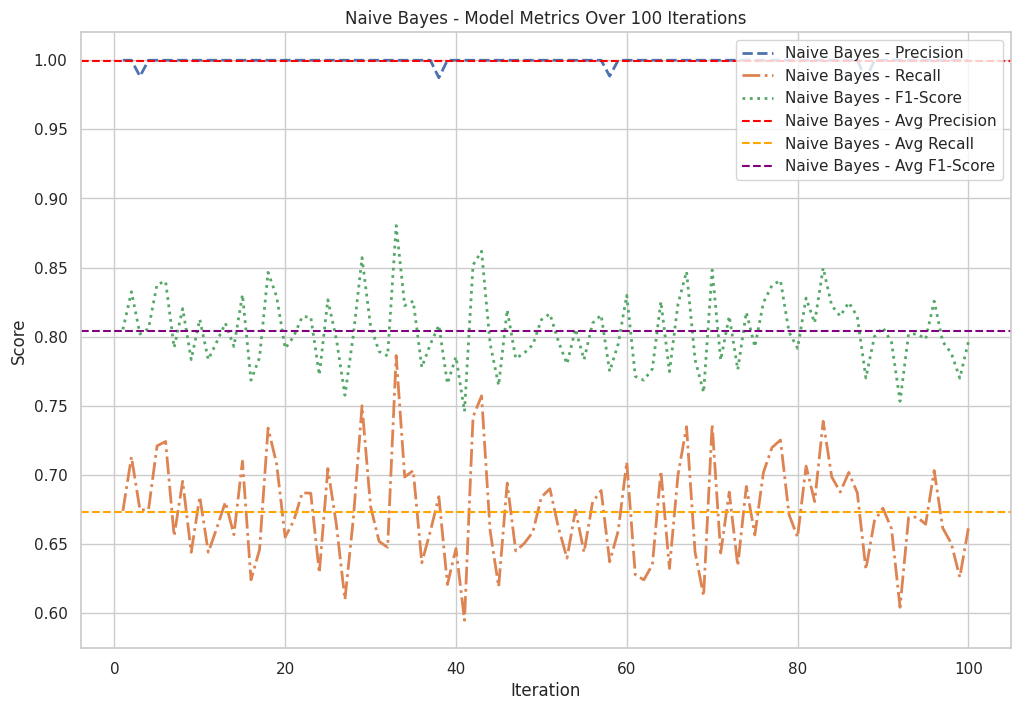

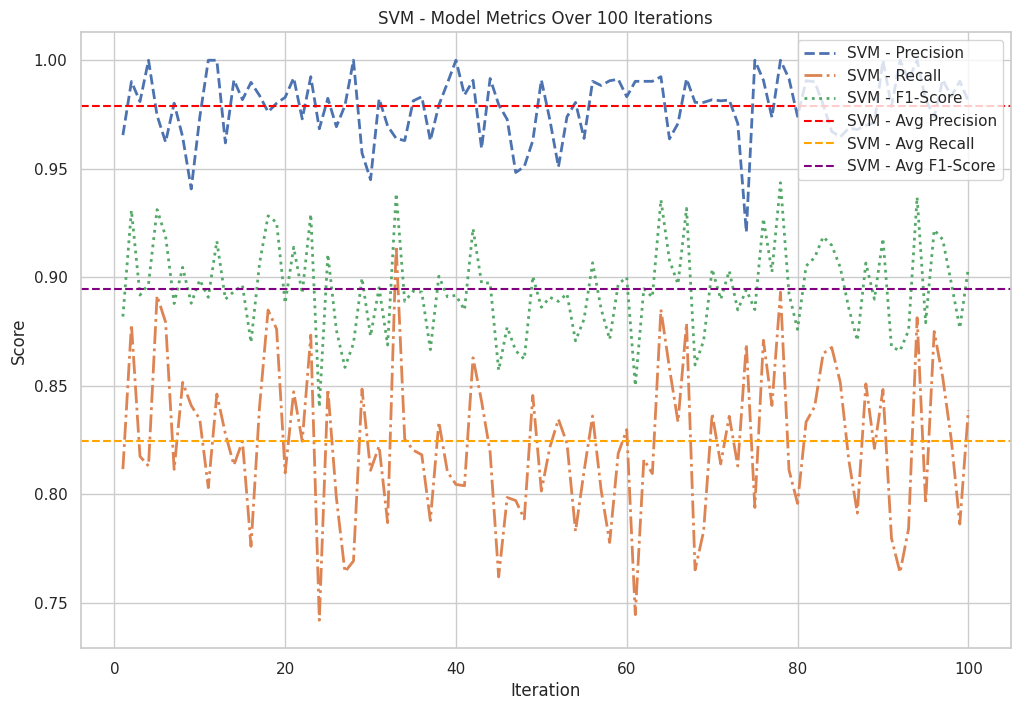

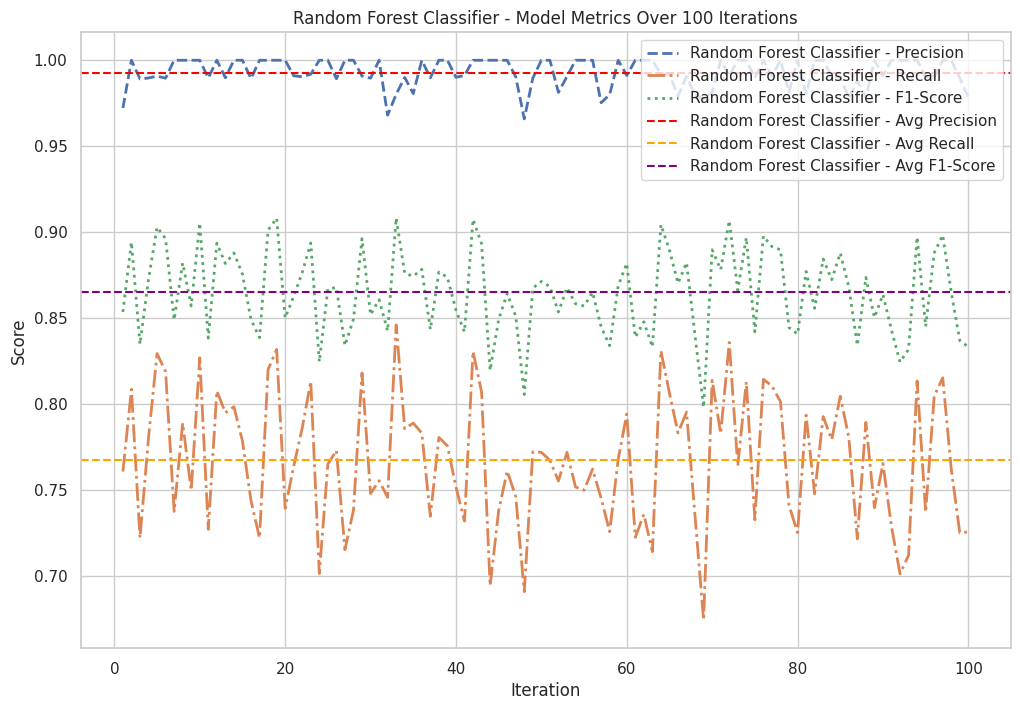

In [ ]:
for model_name in models.keys():
    plt.figure(figsize=(12, 8))

    plt.plot(range(1, n_iterations + 1), all_metrics[model_name]["precision"], label=f"{model_name} - Precision", linestyle='--', linewidth=2)
    plt.plot(range(1, n_iterations + 1), all_metrics[model_name]["recall"], label=f"{model_name} - Recall", linestyle='-.', linewidth=2)
    plt.plot(range(1, n_iterations + 1), all_metrics[model_name]["f1_score"], label=f"{model_name} - F1-Score", linestyle=':', linewidth=2)

    # Plot average lines for each model
    plt.axhline(np.mean(all_metrics[model_name]["precision"]), color='red', linestyle='--', label=f'{model_name} - Avg Precision')
    plt.axhline(np.mean(all_metrics[model_name]["recall"]), color='orange', linestyle='--', label=f'{model_name} - Avg Recall')
    plt.axhline(np.mean(all_metrics[model_name]["f1_score"]), color='purple', linestyle='--', label=f'{model_name} - Avg F1-Score')

    # Customize plot
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title(f'{model_name} - Model Metrics Over 100 Iterations')
    plt.legend(loc='upper right')


    # Show plot
    plt.show()

<ipython-input-105-a513a5e0e0a5>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_accuracy_df, x="Model", y="Accuracy", palette="inferno")


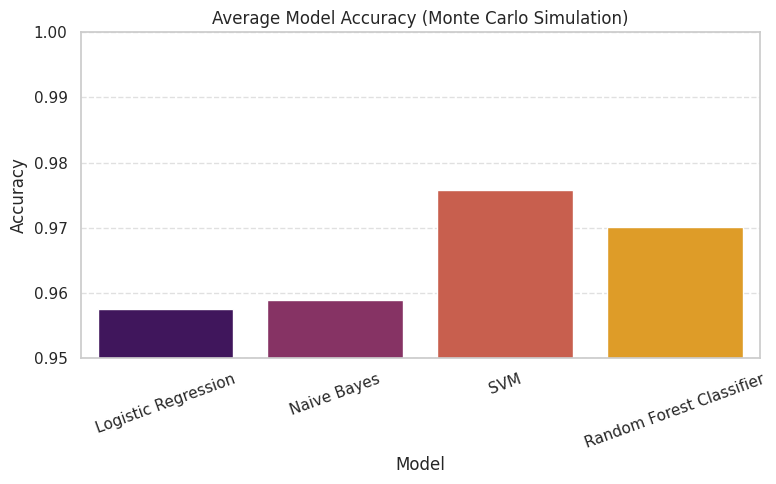

In [ ]:
# Create DataFrame for average accuracies
# --- Plotting average accuracy for all models ---

# Calculate average accuracy for Logistic Regression
logistic_avg_acc = np.mean(logistic_metrics["accuracy"])

# Calculate average accuracy for NB, SVM, and Random Forest
other_models_avg_acc = {
    name: np.mean(metrics["accuracy"]) for name, metrics in all_metrics.items()
}

# Combine all models' average accuracies for plotting
avg_accuracy_df = pd.DataFrame({
    "Model": ["Logistic Regression"] + list(other_models_avg_acc.keys()),
    "Accuracy": [logistic_avg_acc] + list(other_models_avg_acc.values())
})


# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_accuracy_df, x="Model", y="Accuracy", palette="inferno")
plt.title("Average Model Accuracy (Monte Carlo Simulation)")
plt.ylabel("Accuracy")
plt.ylim(0.95, 1.0)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


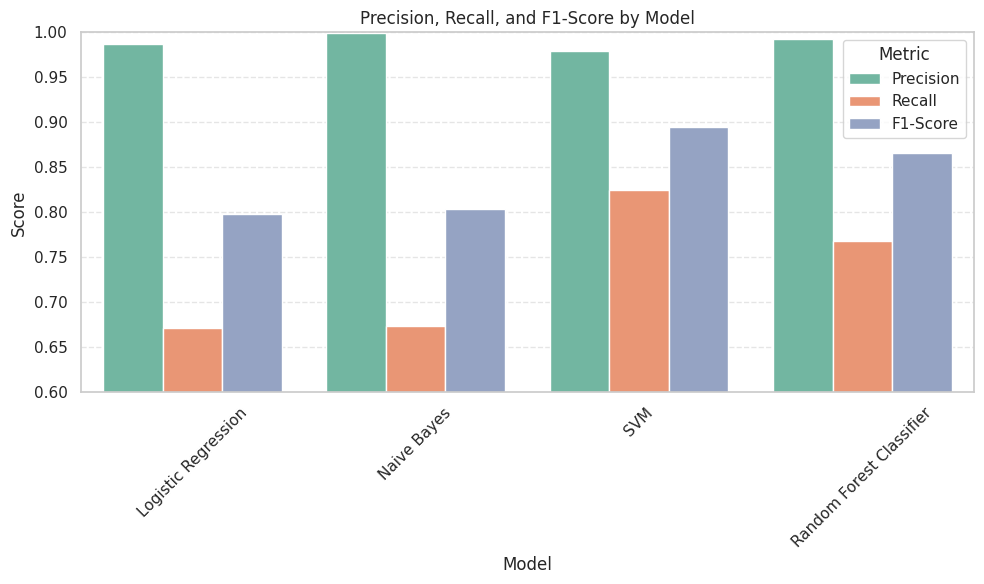

In [ ]:
# Create dataframe for averaged metrics
# Calculate average precision, recall, and F1 for Logistic Regression (excluding accuracy)
logistic_avg_prec = np.mean(logistic_metrics["precision"])
logistic_avg_rec = np.mean(logistic_metrics["recall"])
logistic_avg_f1 = np.mean(logistic_metrics["f1_score"])

# Calculate average precision, recall, and F1 for NB, SVM, and Random Forest (excluding accuracy)
other_models_avg = {
    name: {
        "precision": np.mean(metrics["precision"]),
        "recall": np.mean(metrics["recall"]),
        "f1_score": np.mean(metrics["f1_score"]),
    }
    for name, metrics in all_metrics.items()
}

# Combine all models' average precision, recall, and F1 for plotting
avg_models_df = pd.DataFrame({
    "Model": ["Logistic Regression"] + list(other_models_avg.keys()),
    "Precision": [logistic_avg_prec] + [other_models_avg[name]["precision"] for name in other_models_avg],
    "Recall": [logistic_avg_rec] + [other_models_avg[name]["recall"] for name in other_models_avg],
    "F1-Score": [logistic_avg_f1] + [other_models_avg[name]["f1_score"] for name in other_models_avg],
})

# Melt the DataFrame to long format
metrics_melted = avg_models_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="Set2")
plt.title("Precision, Recall, and F1-Score by Model")
plt.ylim(0.6, 1.0)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


While Naive Bayes offers the highest prediction value, its F1-score and Recall are among the lowest of the four models I evaluated. The Support Vector Machine (SVM) achieved the best overall performance with an average accuracy of 97.57% and an F1-score of 0.8947, even though it showed a higher degree of variance in accuracy across the 100 iterations compared to NB. With the low variance of accuracy across the split, it can be assumed that NB overfits the data and is therefore unsuitable. SVM indicates a strong precision and reliable spam detection capability. Random Forest followed closely, while Naive Bayes and Logistic Regression showed faster performance with slightly lower recall.